let us start by importing the required functions

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
# import statsemodels.api as sm
import SALib
import seaborn as sns
import mpl_toolkits.axisartist as AA
import mpld3
import scipy as sp
import copy
import matplotlib.ticker as ticker

from ema_workbench import (Model, RealParameter, IntegerParameter, Policy, CategoricalParameter, Constant, TimeSeriesOutcome, ScalarOutcome, perform_experiments, ema_logging, save_results, load_results)
from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS, SequentialEvaluator
from ema_workbench.connectors.pysd_connector import PysdModel 
from ema_workbench.connectors import vensimDLLwrapper
from ema_workbench.connectors.vensim import VensimModel
from ema_workbench.em_framework.samplers import sample_levers, sample_uncertainties
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench.util import load_results
from ema_workbench.util import ema_logging

from ema_workbench.analysis import prim
from ema_workbench.analysis.plotting import lines, multiple_densities, kde_over_time
from ema_workbench.analysis.plotting_util import KDE
from ema_workbench.analysis.plotting_util import determine_time_dimension
from ema_workbench.analysis.pairs_plotting import pairs_scatter

from SALib.sample import saltelli
from SALib.analyze import sobol, morris
from SALib.test_functions import Ishigami

from mpl_toolkits.axes_grid1 import host_subplot

from scipy.stats import linregress

ema_logging.log_to_stderr(ema_logging.INFO)

C:\Users\guri_\Anaconda3\lib\site-packages\ema_workbench\connectors\__init__.py:18: ImportWarning: netlogo connector not available
  warnings.warn("netlogo connector not available", ImportWarning)


<Logger EMA (DEBUG)>

NOTE: I decided not to do scenario discovery at this early phase. scenario discovery at this phase sometimes creates conflicting subspaces for different objectives, and some are not even relevant to land use policy, e.g. directly pointing to immigration rate and fertility rate. So, the idea now is to follow the basic mordm structure. we optimize current land use options available for the objectives through the evolutionary algorithm (since the context is land use policy), do uncertainty analysis, and then do scenario discovery AFTERWARDS by lowering the objective threshold to optimize further. Because the current robustness structure is minimax/maximin. This further optimization can link to other non land use policies, and it is fine because it can pinpoint the fundamental reason of these options to emerge, such as disparity of development between Jakarta and any other cities which cause high immigration rate. 

What we can do after that is to either motivate the PRIM result with text (like Bramka did), to integrate the scenario discovery result to the model and run again, or to design pathways combining the scenario discovery insights. I personally prefer the first option because i dont have time. But if you want to you can do the latter options it is fine. BUT please do not change the current structure for both model and script. Improve it from the last step of this page.

In [2]:
vensimModel = VensimModel("BaseCase", model_file="E:\Study\Delft\Coursework\Year_2\Thesis\SD\Model\BenTre_SD_Extend_9_sep.vpm" )

In [3]:
vensimModel.uncertainties = [

            RealParameter("UpstreamTrapping", 0.9, 1.1),
            RealParameter("SedNutContent", 270, 330),
            RealParameter("FloodDuration", 1, 2),
            RealParameter("ExogNutAvailRate", 8, 15),
            RealParameter("TimeToNutAvailable", 2, 12),     
            RealParameter("MaxNutReqPerHectare", 450, 550),
            RealParameter("YielGrowRate", 1.01, 1.05),
            RealParameter("LeachingRate", 3, 9),
            RealParameter("Salinity Rate", 0.01, 0.1),
            RealParameter("Salinity Fluctuation Intensity", 3, 7),
            RealParameter("crop survival probability", 0.1, 0.5),
            RealParameter("Rate of Degradation", 1, 5),
            RealParameter("BaseTE", 0.25, 0.4),
            RealParameter("TECoefficient", 0.025, 0.04),
            RealParameter("RiceFarmSize", 0.2, 1.5),
            RealParameter("RicePriceChngRate", 1, 1.003),
            RealParameter("RiceStartPrice", 3, 9),
            RealParameter("CostRiceUnit", 1, 8),
            RealParameter("Dredging cost", 500, 2000),
            RealParameter("InitInvestIntenseShrimp", 80000, 150000),
            RealParameter("CostExtense", 0.03, 0.05),
            RealParameter("CostIntense", 0.6, 1.2),
            RealParameter("CostFresh", 0.8, 1.8),
            RealParameter("IntenShrimpFarmArea",0.1,0.5),
            RealParameter("ExtShrimpFarmArea", 0.8, 1.2),
            RealParameter("intenseSelling", 0.6, 1.3),
            RealParameter("Extense Selling", 3, 8),
            RealParameter("Fresh Selling", 9, 15),
            RealParameter("Extensive Shrimp Recruitment per hectare", 75000, 125000),
            RealParameter("Extensive Shrimp Survival Rate", 0.05, 0.4),
            RealParameter("Intensive Shrimp recruitment per hectare", 800000, 1400000),
            RealParameter("Intensive Shrimp Survival Rate", 0.5, 0.98),
            RealParameter("Freshwater Shrimp Recruitment per hectare", 10000 ,30000),
            RealParameter("Freshwater Shrimp Survival Rate",0.2, 0.5),
            RealParameter("MinWage",5000,20000),
            RealParameter("BackupFraction",1.05,1.3),
            RealParameter("FertPriceChngRate",1.01,1.05),
            RealParameter("FertStartPrice",3,8),   
            RealParameter("PopFracExtensive", 0, 0.5),
            RealParameter("PopFracInteg", 0, 0.5)    
]

vensimModel.outcomes = [
    TimeSeriesOutcome('Regional Soil Nutrient Balance'),
    TimeSeriesOutcome('Regional Water Pollution'),
    TimeSeriesOutcome('Regional Economic Position')
]

In [4]:
results = perform_experiments(vensimModel, 100, uncertainty_sampling=LHS)

[MainProcess/INFO] performing 100 scenarios * 1 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 10 cases completed
[MainProcess/INFO] 20 cases completed
[MainProcess/INFO] 30 cases completed
[MainProcess/INFO] 40 cases completed
[MainProcess/INFO] 50 cases completed
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] 70 cases completed
[MainProcess/INFO] 80 cases completed
[MainProcess/INFO] 90 cases completed
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] experiments finished


In [5]:
results_name = './BenTre_SD_Test_BaseCase_LHS_100.tar.gz'
save_results(results, results_name)

[MainProcess/INFO] results saved successfully to E:\Study\Delft\Coursework\Year_2\Thesis\SD\Code\BenTre_SD_Test_BaseCase_LHS_100.tar.gz


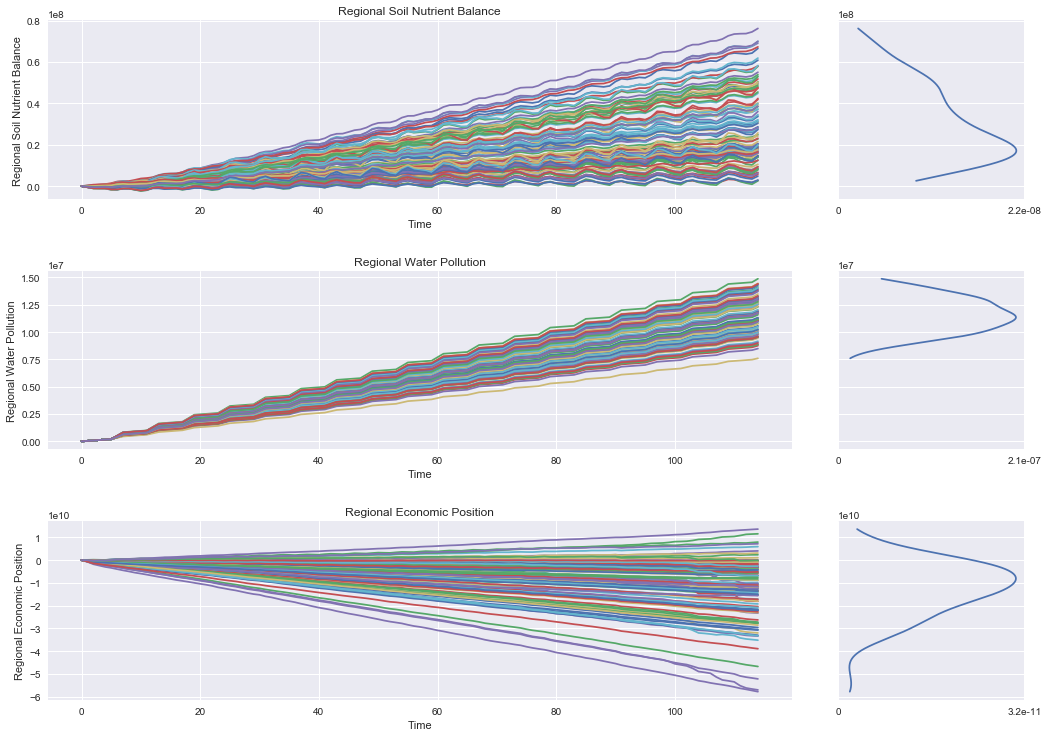

In [7]:
figure = lines(results,density=u'kde') #show lines, and end state density
plt.show() #show figure

In [6]:
plt.rcParams["figure.figsize"] = (17.5,12.5)

In [2]:
# Load results (these can be generated with RunExperiments.ipynb if necessary)
results = load_results('./BenTre_SD_Test_BaseCase_LHS_100.tar.gz')

[MainProcess/INFO] results loaded succesfully from E:\Study\Delft\Coursework\Year_2\Thesis\SD\Code\BenTre_SD_Test_BaseCase_LHS_100.tar.gz


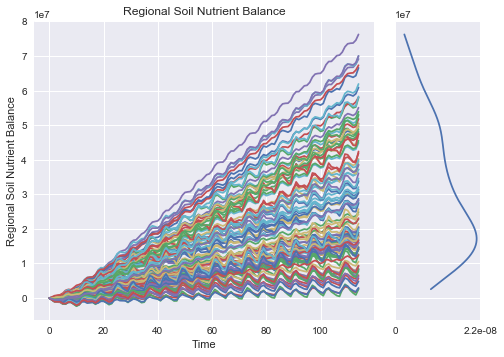

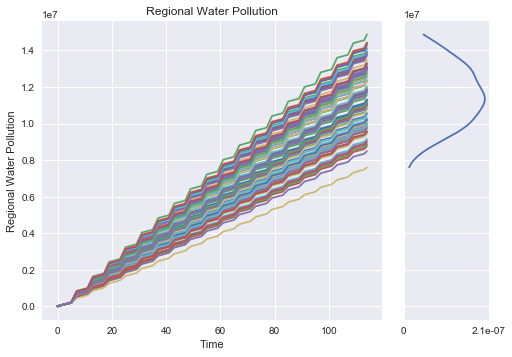

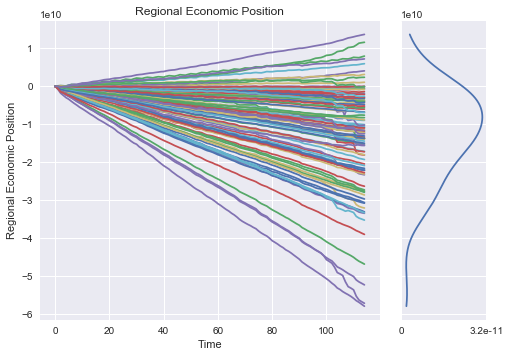

In [3]:
outputs = list(results[1].keys())[1:] 

for x in outputs:
    fig = lines(results, outcomes_to_show=[x], density=KDE)
plt.show()

In [11]:
experiments, outcomes = results

In [13]:
ema_logging.log_to_stderr(ema_logging.INFO)

#10 is chosen as threshold since it indicates the point above which houses are deemed severely unaffordable (literature-based).

def classifyHAfford(data):
    ooi = 'Regional Economic Position'
    outcome = np.mean(outcomes[ooi], axis=1)
    classes = np.zeros(outcome.shape[0])
    classes[outcome<0] = 1
    return classes



In [14]:
prim_obj = prim.setup_prim(results, classifyHAfford, threshold=0.8)
box_1 = prim_obj.find_box()

[MainProcess/INFO] 100 points remaining, containing 90 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.64, coverage: 0.7111111111111111, density: 1.0 restricted_dimensions: 5


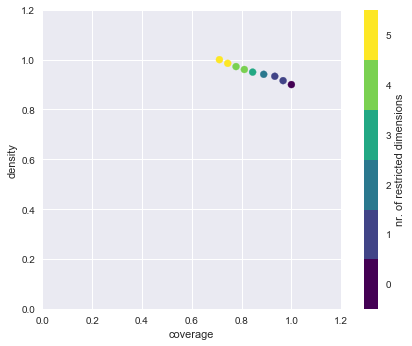

In [16]:
box_1.show_tradeoff()
# mpld3.display()

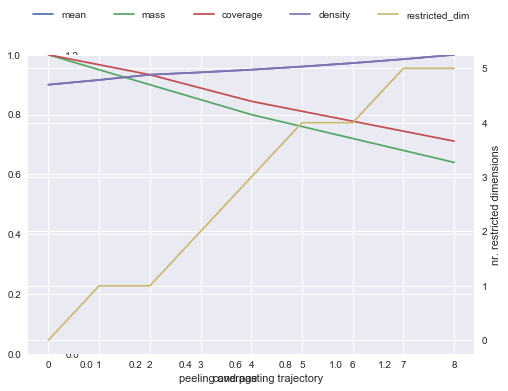

In [17]:
box_1.show_ppt()
plt.show()

coverage    0.888889
density     0.941176
mass            0.85
mean        0.941176
res dim            2
Name: 3, dtype: object

                box 3                                 
                  min       max              qp values
CostExtense  0.031996  0.049873   [0.1729700754015602]
BaseTE       0.250175  0.392845  [0.49671392748278154]



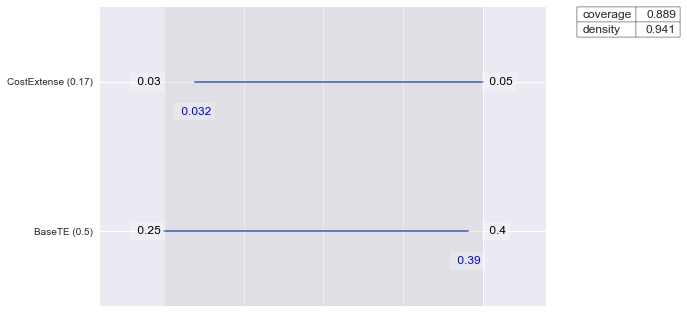

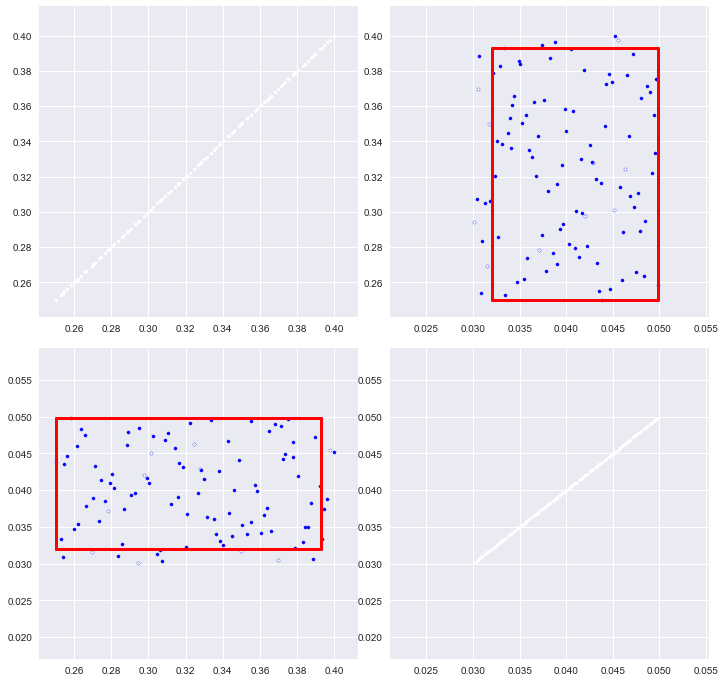

In [23]:
valuebox = 3
box_1.inspect(valuebox)
box_1.select(valuebox)

top_box = valuebox
box_1.inspect(top_box, style='graph')

fig = box_1.show_pairs_scatter()
fig.set_size_inches((12,12))
plt.show()
plt.close()

In [33]:
ema_logging.log_to_stderr(ema_logging.INFO)

#10 is chosen as threshold since it indicates the point above which houses are deemed severely unaffordable (literature-based).

def classifyNoSettle(data):
    ooi = 'Regional Water Pollution'
    outcome = np.mean(outcomes[ooi], axis=1)
    classes = np.zeros(outcome.shape[0])
    classes[outcome>5000000] = 1
    return classes


prim_obj = prim.setup_prim(results, classifyNoSettle, threshold=0.8)
box_1 = prim_obj.find_box()

[MainProcess/INFO] 100 points remaining, containing 78 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.54, coverage: 0.6923076923076923, density: 1.0 restricted_dimensions: 8


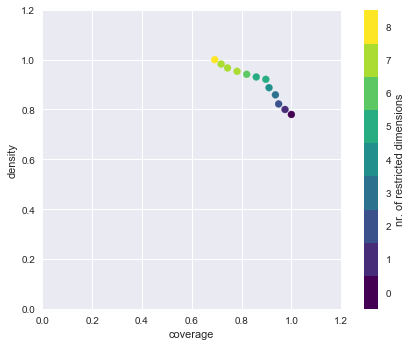

In [34]:
box_1.show_tradeoff()
# mpld3.display()

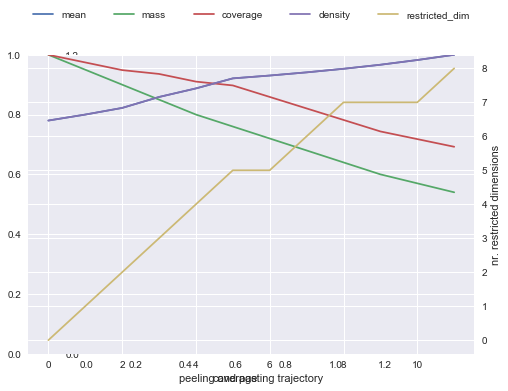

In [35]:
box_1.show_ppt()
plt.show()

coverage    0.897436
density     0.921053
mass            0.76
mean        0.921053
res dim            5
Name: 5, dtype: object

                                box 5                                      
                                  min            max              qp values
PopFracExtensive             0.003242       0.470045  [0.15662368947002886]
FloodDuration                1.003969       1.952906  [0.23493824293285945]
SedNutContent              270.220679     327.592034  [0.23493824293285945]
ExtShrimpFarmArea            0.802806       1.179598  [0.24656047594842065]
InitInvestIntenseShrimp  80651.104285  146595.691943  [0.24656047594842065]



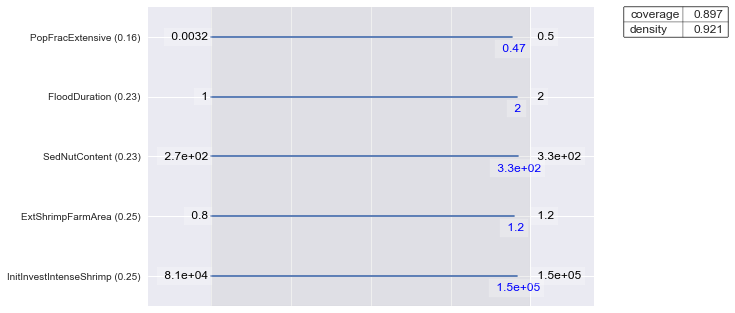

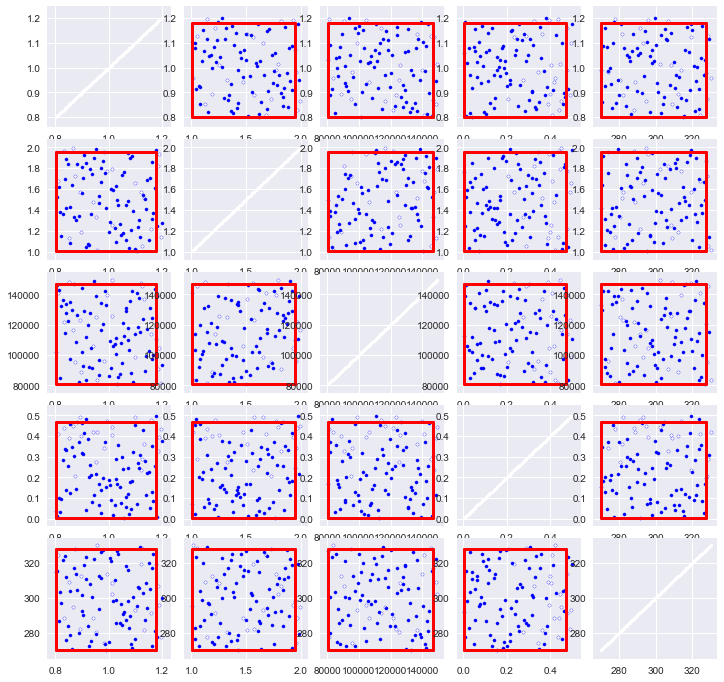

In [37]:
valuebox = 5
box_1.inspect(valuebox)
box_1.select(valuebox)

top_box = valuebox
box_1.inspect(top_box, style='graph')

fig = box_1.show_pairs_scatter()
fig.set_size_inches((12,12))
plt.show()
plt.close()

In [43]:
def classifyUrbanNon(data):
    ooi = 'Regional Soil Nutrient Balance'
    outcome = np.mean(outcomes[ooi], axis=1)
    classes = np.zeros(outcome.shape[0])
    classes[outcome<8000000] = 1
    return classes


prim_obj = prim.setup_prim(results, classifyUrbanNon, threshold=0.8)
box_2 = prim_obj.find_box()

[MainProcess/INFO] 100 points remaining, containing 30 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.21, coverage: 0.7, density: 1.0 restricted_dimensions: 10


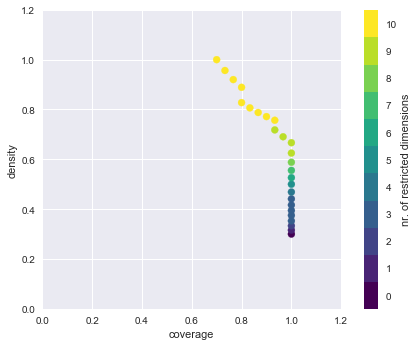

In [44]:
box_2.show_tradeoff()
# mpld3.display()

coverage         0.9
density     0.771429
mass            0.35
mean        0.771429
res dim           10
Name: 18, dtype: object

                                                 box 18                \
                                                    min           max   
FloodDuration                                  1.003969  1.771283e+00   
Dredging cost                                663.063175  1.936403e+03   
TimeToNutAvailable                             2.826714  1.190731e+01   
Intensive Shrimp recruitment per hectare  805826.381182  1.382063e+06   
PopFracExtensive                               0.003242  4.679577e-01   
RiceFarmSize                                   0.204050  1.463269e+00   
BaseTE                                         0.257287  3.908546e-01   
FertPriceChngRate                              1.010358  1.048000e+00   
InitInvestIntenseShrimp                    80651.104285  1.444331e+05   
intenseSelling                                 0.661923  1.294902e+

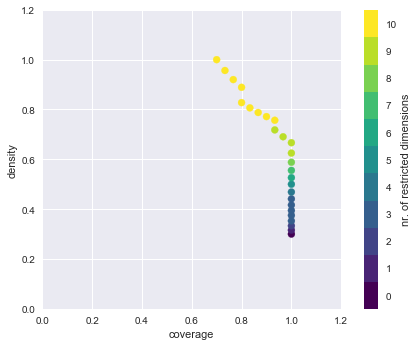

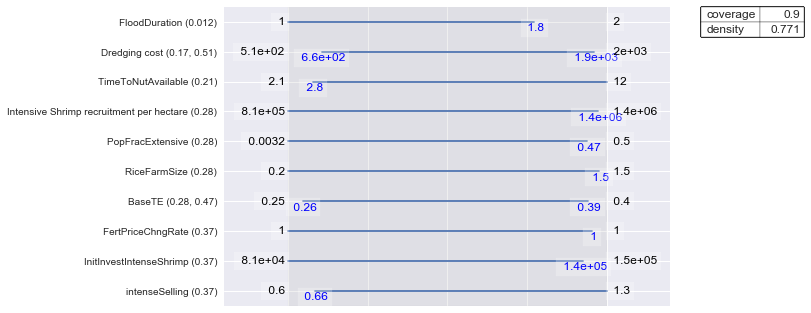

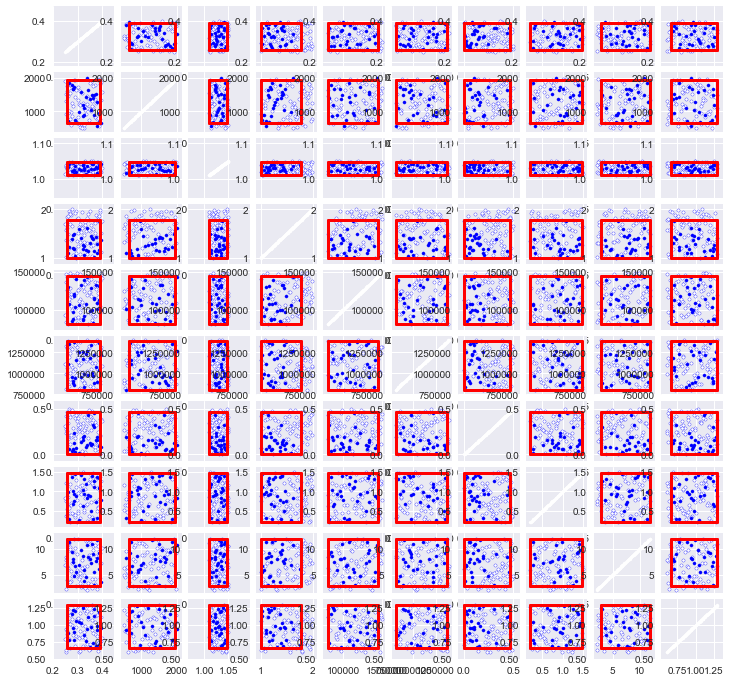

In [45]:
valuebox = 18
box_2.inspect(valuebox)
box_2.select(valuebox)

top_box = valuebox
box_2.inspect(top_box, style='graph')

fig = box_2.show_pairs_scatter()
fig.set_size_inches((12,12))
plt.show()
plt.close()

In [47]:
vensimModel = VensimModel("BaseCaseshort", model_file="E:\Study\Delft\Coursework\Year_2\Thesis\SD\Model\BenTre_SD_Extend_9_sep_short.vpm" )

In [48]:
vensimModel.uncertainties = [

            RealParameter("UpstreamTrapping", 0.9, 1.1),
            RealParameter("SedNutContent", 270, 330),
            RealParameter("FloodDuration", 1, 2),
            RealParameter("ExogNutAvailRate", 8, 15),
            RealParameter("TimeToNutAvailable", 2, 12),     
            RealParameter("MaxNutReqPerHectare", 450, 550),
            RealParameter("YielGrowRate", 1.01, 1.05),
            RealParameter("LeachingRate", 3, 9),
            RealParameter("Salinity Rate", 0.01, 0.1),
            RealParameter("Salinity Fluctuation Intensity", 3, 7),
            RealParameter("crop survival probability", 0.1, 0.5),
            RealParameter("Rate of Degradation", 1, 5),
            RealParameter("BaseTE", 0.25, 0.4),
            RealParameter("TECoefficient", 0.025, 0.04),
            RealParameter("RiceFarmSize", 0.2, 1.5),
            RealParameter("RicePriceChngRate", 1, 1.003),
            RealParameter("RiceStartPrice", 3, 9),
            RealParameter("CostRiceUnit", 1, 8),
            RealParameter("Dredging cost", 500, 2000),
            RealParameter("InitInvestIntenseShrimp", 80000, 150000),
            RealParameter("CostExtense", 0.03, 0.05),
            RealParameter("CostIntense", 0.6, 1.2),
            RealParameter("CostFresh", 0.8, 1.8),
            RealParameter("IntenShrimpFarmArea",0.1,0.5),
            RealParameter("ExtShrimpFarmArea", 0.8, 1.2),
            RealParameter("intenseSelling", 0.6, 1.3),
            RealParameter("Extense Selling", 3, 8),
            RealParameter("Fresh Selling", 9, 15),
            RealParameter("Extensive Shrimp Recruitment per hectare", 75000, 125000),
            RealParameter("Extensive Shrimp Survival Rate", 0.05, 0.4),
            RealParameter("Intensive Shrimp recruitment per hectare", 800000, 1400000),
            RealParameter("Intensive Shrimp Survival Rate", 0.5, 0.98),
            RealParameter("Freshwater Shrimp Recruitment per hectare", 10000 ,30000),
            RealParameter("Freshwater Shrimp Survival Rate",0.2, 0.5),
            RealParameter("MinWage",5000,20000),
            RealParameter("BackupFraction",1.05,1.3),
            RealParameter("FertPriceChngRate",1.01,1.05),
            RealParameter("FertStartPrice",3,8),   
            RealParameter("PopFracExtensive", 0.001, 0.5),
            RealParameter("PopFracInteg", 0.001, 0.5)    
]

vensimModel.outcomes = [
    TimeSeriesOutcome('Regional Soil Nutrient Balance'),
    TimeSeriesOutcome('Regional Water Pollution'),
    TimeSeriesOutcome('Regional Economic Position')
]

In [49]:
results = perform_experiments(vensimModel, 100, uncertainty_sampling=LHS)

[MainProcess/INFO] performing 100 scenarios * 1 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 10 cases completed
[MainProcess/INFO] 20 cases completed
[MainProcess/INFO] 30 cases completed
[MainProcess/INFO] 40 cases completed
[MainProcess/INFO] 50 cases completed
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] 70 cases completed
[MainProcess/INFO] 80 cases completed
[MainProcess/INFO] 90 cases completed
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] experiments finished


In [50]:
results_name = './BenTre_SD_Test_BaseCase_LHS_100_short.tar.gz'
save_results(results, results_name)

[MainProcess/INFO] results saved successfully to E:\Study\Delft\Coursework\Year_2\Thesis\SD\Code\BenTre_SD_Test_BaseCase_LHS_100_short.tar.gz


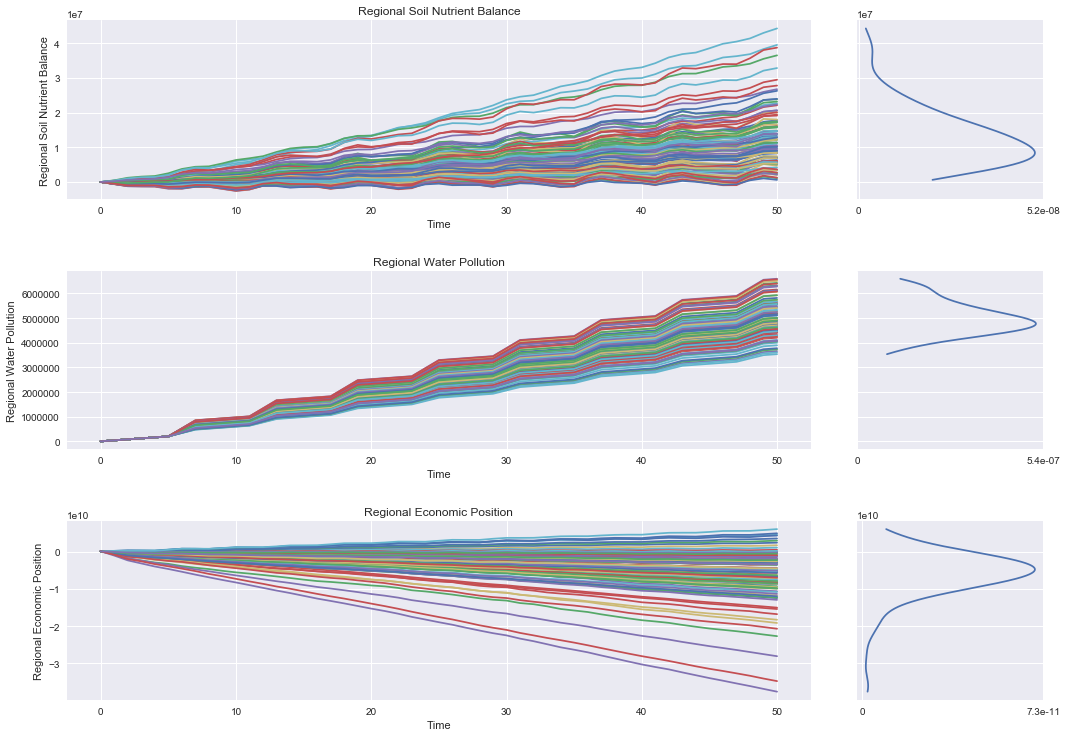

In [53]:
figure = lines(results,density=u'kde') #show lines, and end state density
plt.show() #show figure

In [52]:
plt.rcParams["figure.figsize"] = (17.5,12.5)

In [2]:
# Load results (these can be generated with RunExperiments.ipynb if necessary)
results = load_results('./BenTre_SD_Test_BaseCase_LHS_100_short.tar.gz')

[MainProcess/INFO] results loaded succesfully from E:\Study\Delft\Coursework\Year_2\Thesis\SD\Code\BenTre_SD_Test_BaseCase_LHS_100.tar.gz


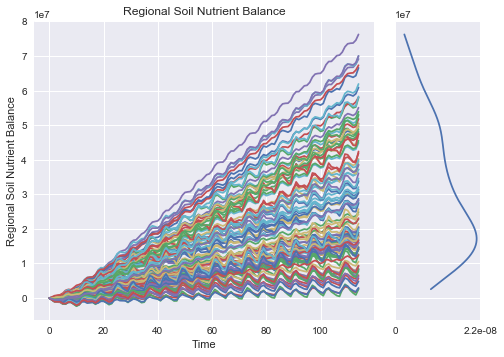

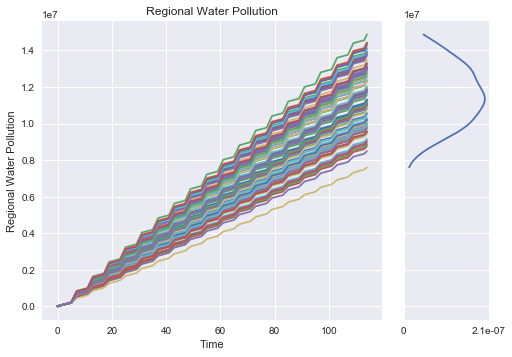

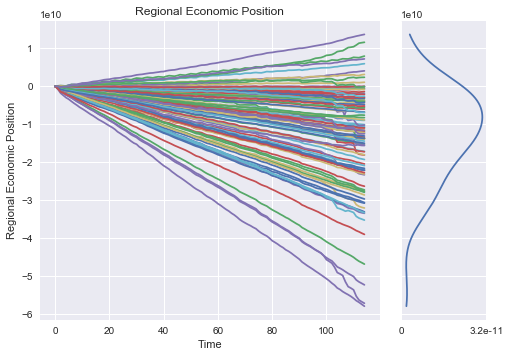

In [3]:
outputs = list(results[1].keys())[1:] 

for x in outputs:
    fig = lines(results, outcomes_to_show=[x], density=KDE)
plt.show()

In [63]:
def classifyBoth(data):
    ooi_d = 'People with No Settlements'
    result_d = data[ooi_d]
    
    ooi_i = 'Illegal Slum Population'
    result_i = np.max(data[ooi_i], axis=1)
    
    #make an empty array of length equal to number of cases 
    classes = np.zeros(result_d.shape[0])
    
    #combine infectious and deceased checks
    classes[(result_d[:, -1] > 9000000) 
            & (result_i > 100000)] = 1
    
    return classes

combo_prim = prim.setup_prim(results, classifyBoth,  
                           threshold=0.8, threshold_type=1)
box1 = combo_prim.find_box()

[MainProcess/INFO] 3000 points remaining, containing 2934 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.6623333333333333, coverage: 0.6772324471710974, density: 1.0 restricted_dimensions: 3


In [64]:
box1.show_tradeoff()
mpld3.display()

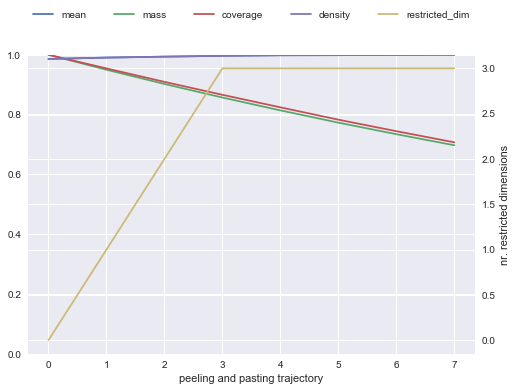

In [50]:
box1.show_ppt()
plt.show()

coverage    0.866126
density     0.996499
mass           0.857
mean        0.996499
res dim            3
Name: 3, dtype: object

                                box 3                    
                                  min       max qp values
Base Slum reconversion rate  0.012500  0.059987  0.005141
average Immigration percent  0.012430  0.059994  0.039838
average Emmigration percent  0.010068  0.049994  0.039957



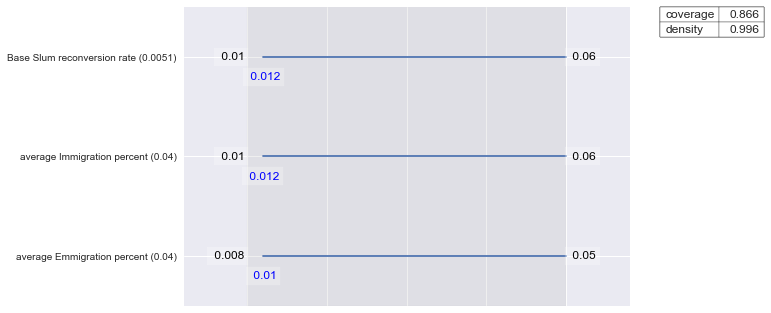

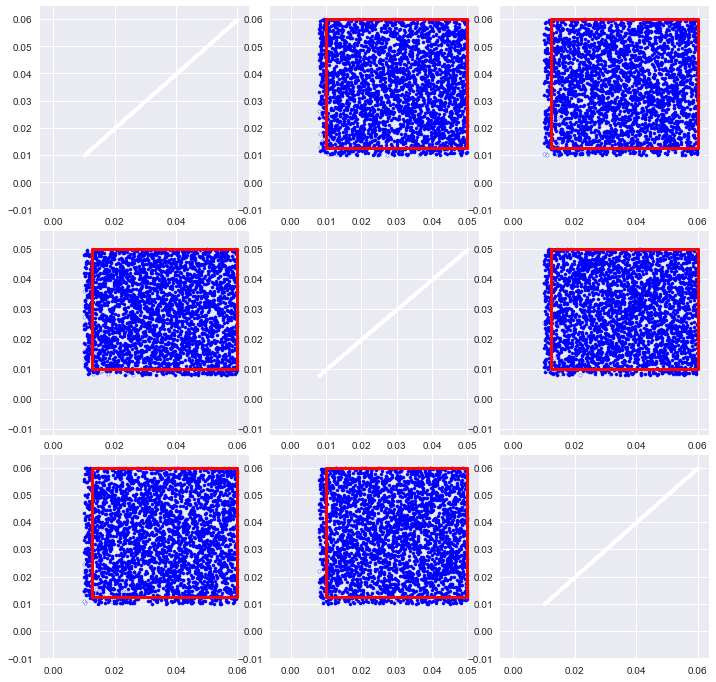

In [51]:
valuebox = 3
box1.inspect(valuebox)
box1.select(valuebox)

top_box = valuebox
box1.inspect(top_box, style='graph')

fig = box1.show_pairs_scatter()
fig.set_size_inches((12,12))
plt.show()
plt.close()

In [9]:
def classifyGreenA(data):
    ooi = 'Green Area'
    outcome = np.mean(outcomes[ooi], axis=1)
    classes = np.zeros(outcome.shape[0])
    classes[outcome<8] = 1
    return classes


prim_obj = prim.setup_prim(results, classifyGreenA, threshold=0.8)
box_3 = prim_obj.find_box()

[MainProcess/INFO] 3000 points remaining, containing 2604 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.486, coverage: 0.5599078341013825, density: 1.0 restricted_dimensions: 2


In [10]:
box_3.show_tradeoff()
mpld3.display()

coverage    0.789939
density      0.98327
mass        0.697333
mean         0.98327
res dim            2
Name: 7, dtype: object

                                         box 7                        
                                           min       max     qp values
Base Economic area Conversion rate    0.023277  0.059987  6.005894e-69
Base Green Area commisioned per year  0.020007  0.057957  9.742786e-03



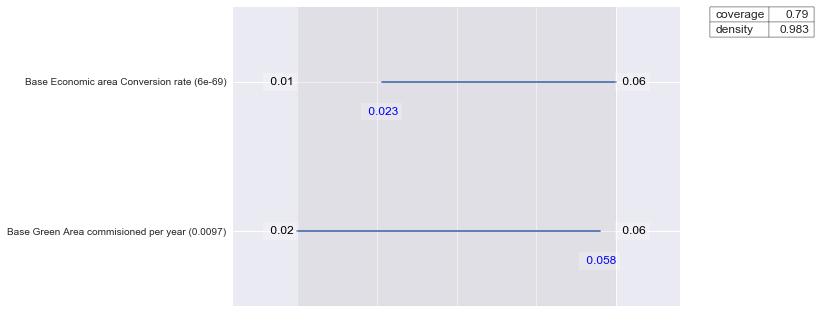

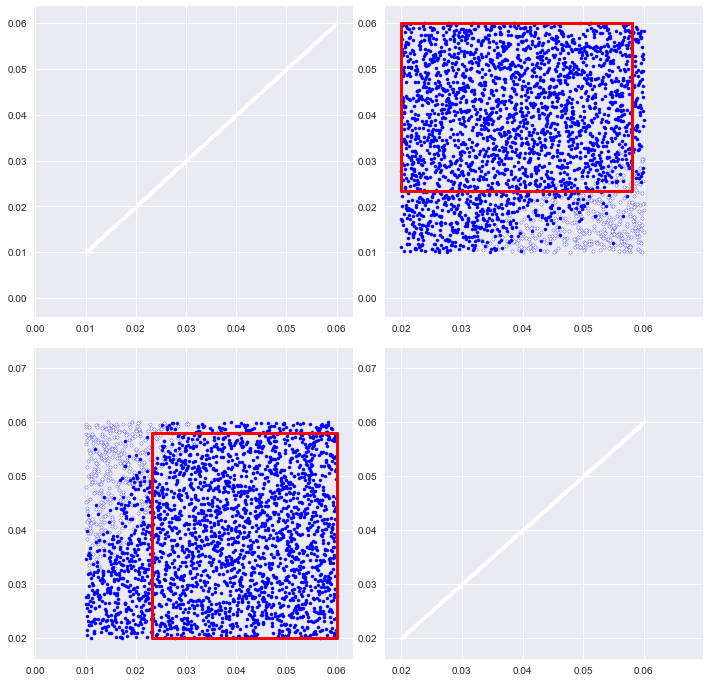

In [11]:
valuebox = 7
box_3.inspect(valuebox)
box_3.select(valuebox)

top_box = valuebox
box_3.inspect(top_box, style='graph')

fig = box_3.show_pairs_scatter()
fig.set_size_inches((12,12))
plt.show()
plt.close()